In [1]:
!pip install category_encoders

In [2]:
!pip install boruta

In [3]:
!pip install scikit-optimize

In [4]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import math
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import datetime as dt
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from skopt import gp_minimize
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn import metrics
import scipy.stats as stats
from scipy.stats import skew


In [5]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fraudTrain.csv", index_col=0)
pd.options.display.float_format = '{:,.2f}'.format

In [6]:
train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.15,-112.15,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.23,-112.11,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.03,-112.56,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.42,-79.46,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.67,-78.63,0


In [7]:
train.shape

(1296675, 22)

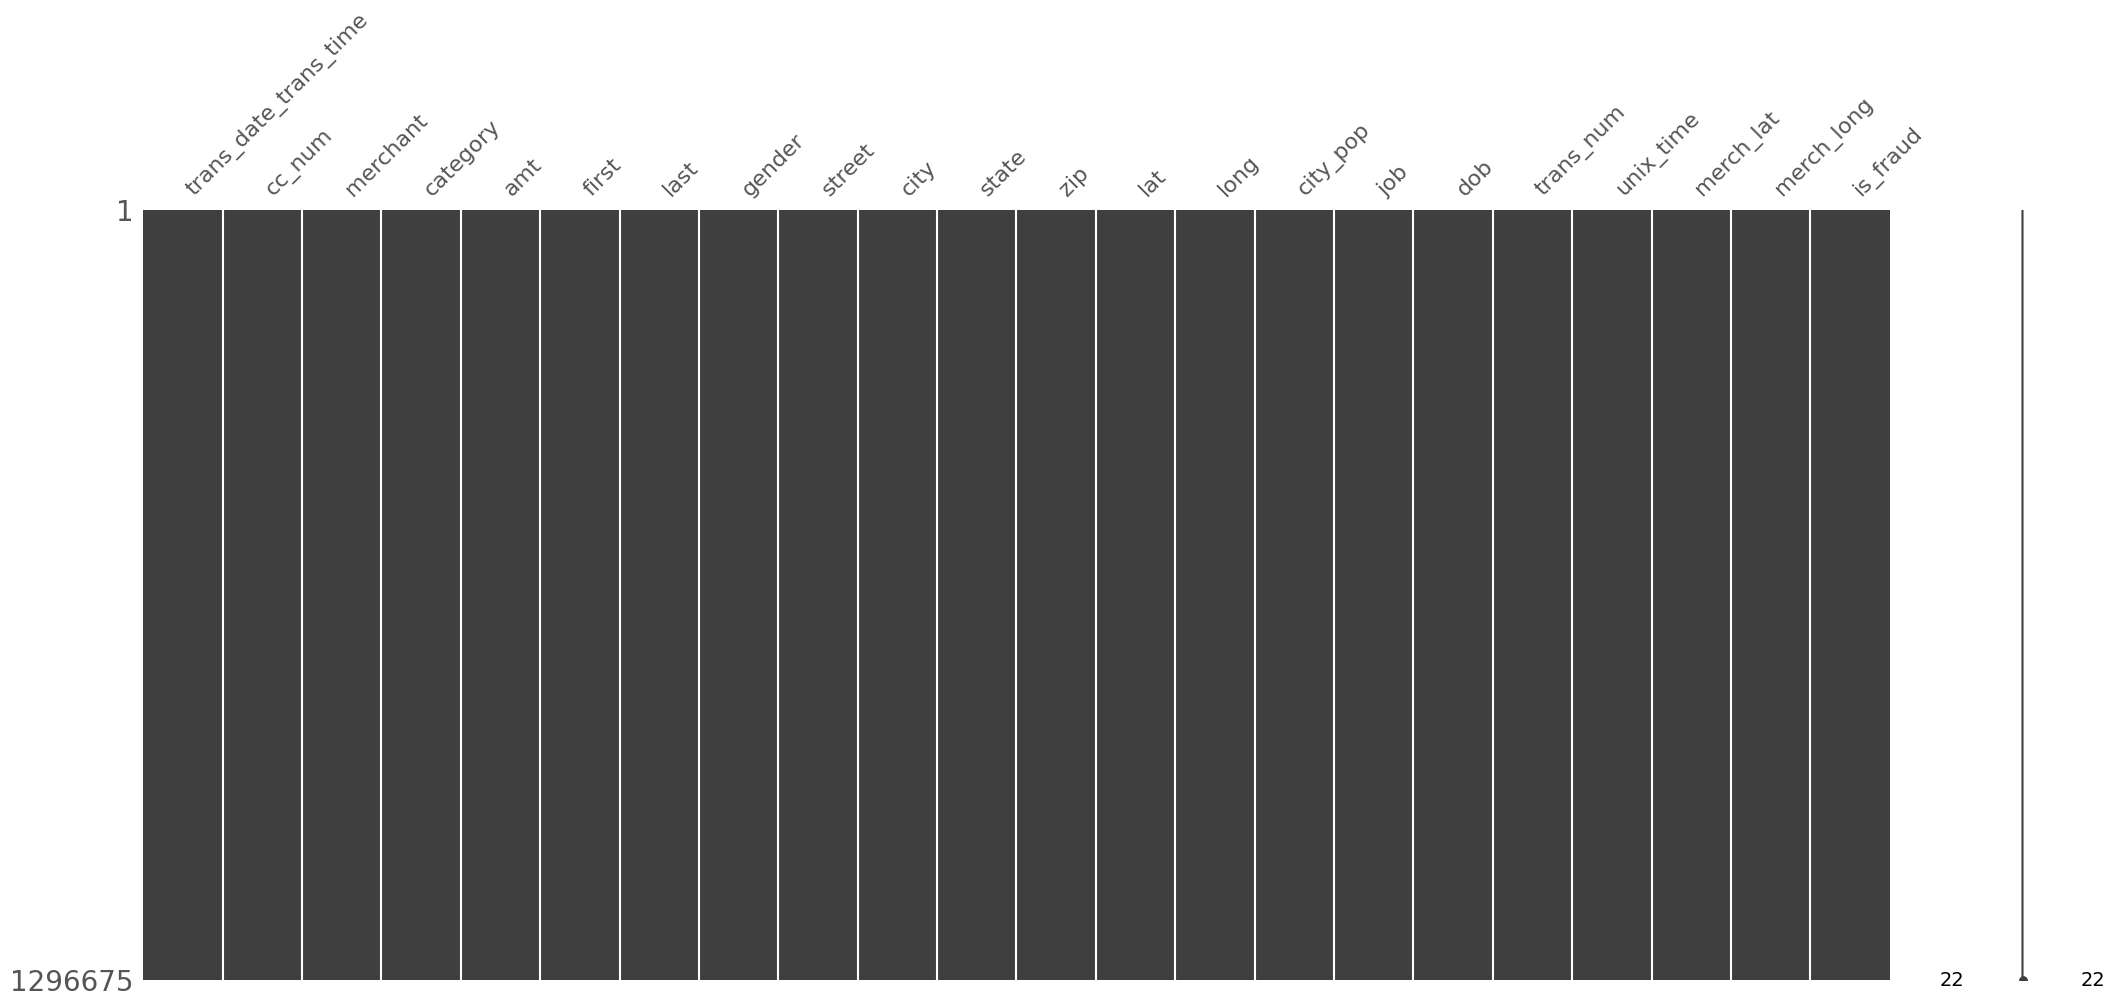

In [8]:
msno.matrix(train);

In [9]:
train.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_num,"1,296,675.00","417,192,042,079,726,656.00","1,308,806,447,000,240,384.00","60,416,207,185.00","180,042,946,491,150.00","3,521,417,320,836,166.00","4,642,255,475,285,942.00","4,992,346,398,065,154,048.00"
amt,"1,296,675.00",70.35,160.32,1.00,9.65,47.52,83.14,"28,948.90"
zip,"1,296,675.00","48,800.67","26,893.22","1,257.00","26,237.00","48,174.00","72,042.00","99,783.00"
lat,"1,296,675.00",38.54,5.08,20.03,34.62,39.35,41.94,66.69
long,"1,296,675.00",-90.23,13.76,-165.67,-96.80,-87.48,-80.16,-67.95
city_pop,"1,296,675.00","88,824.44","301,956.36",23.00,743.00,"2,456.00","20,328.00","2,906,700.00"
unix_time,"1,296,675.00","1,349,243,636.73","12,841,278.42","1,325,376,018.00","1,338,750,742.50","1,349,249,747.00","1,359,385,375.50","1,371,816,817.00"
merch_lat,"1,296,675.00",38.54,5.11,19.03,34.73,39.37,41.96,67.51
merch_long,"1,296,675.00",-90.23,13.77,-166.67,-96.90,-87.44,-80.24,-66.95
is_fraud,"1,296,675.00",0.01,0.08,0.00,0.00,0.00,0.00,1.00


In [11]:
train['amt'].describe()

count   1,296,675.00
mean           70.35
std           160.32
min             1.00
25%             9.65
50%            47.52
75%            83.14
max        28,948.90
Name: amt, dtype: float64

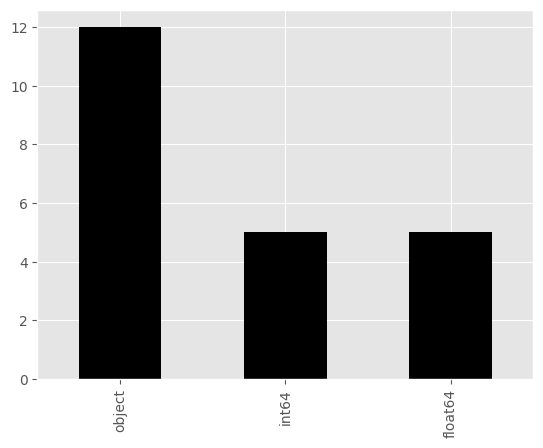

In [12]:
train.dtypes.value_counts().plot(kind='bar', color="black");

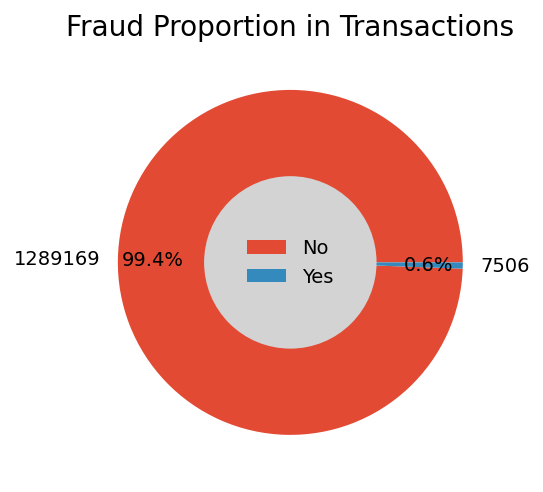

In [13]:
donut = train["is_fraud"].value_counts().reset_index()

labels = ["No", "Yes"]
explode = (0, 0)

fig, ax = plt.subplots(dpi=140, figsize=(8, 4))
plt.pie(donut["is_fraud"],
        labels=donut["is_fraud"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='lightgrey')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Fraud Proportion in Transactions")
plt.legend(labels, loc="center", frameon=False)
plt.show();

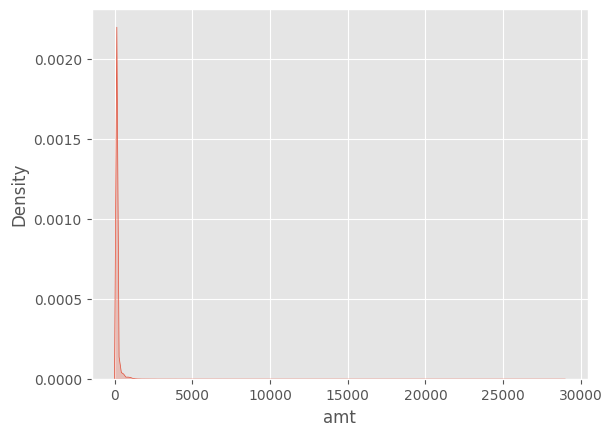

In [14]:
sns.kdeplot(train["amt"], fill=True);

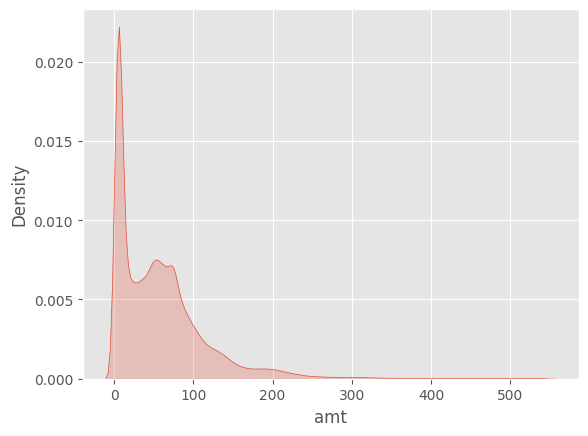

In [15]:
p99 = train["amt"].quantile(0.99)
sns.kdeplot(x="amt", data=train[train["amt"] <= p99], fill=True);

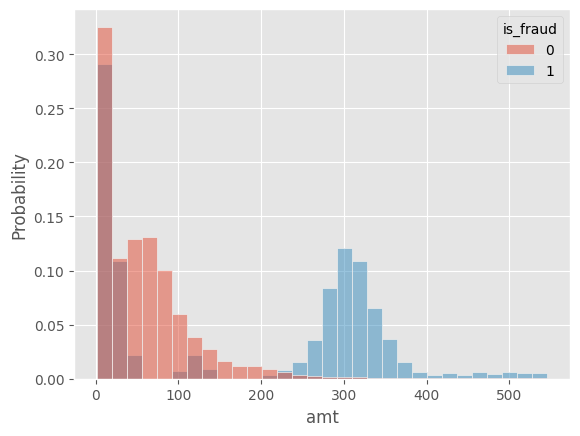

In [16]:
p99 = train["amt"].quantile(0.99)
sns.histplot(x="amt", hue="is_fraud", bins=30,
             stat="probability", data=train[train["amt"] <= p99],
             common_norm=False);

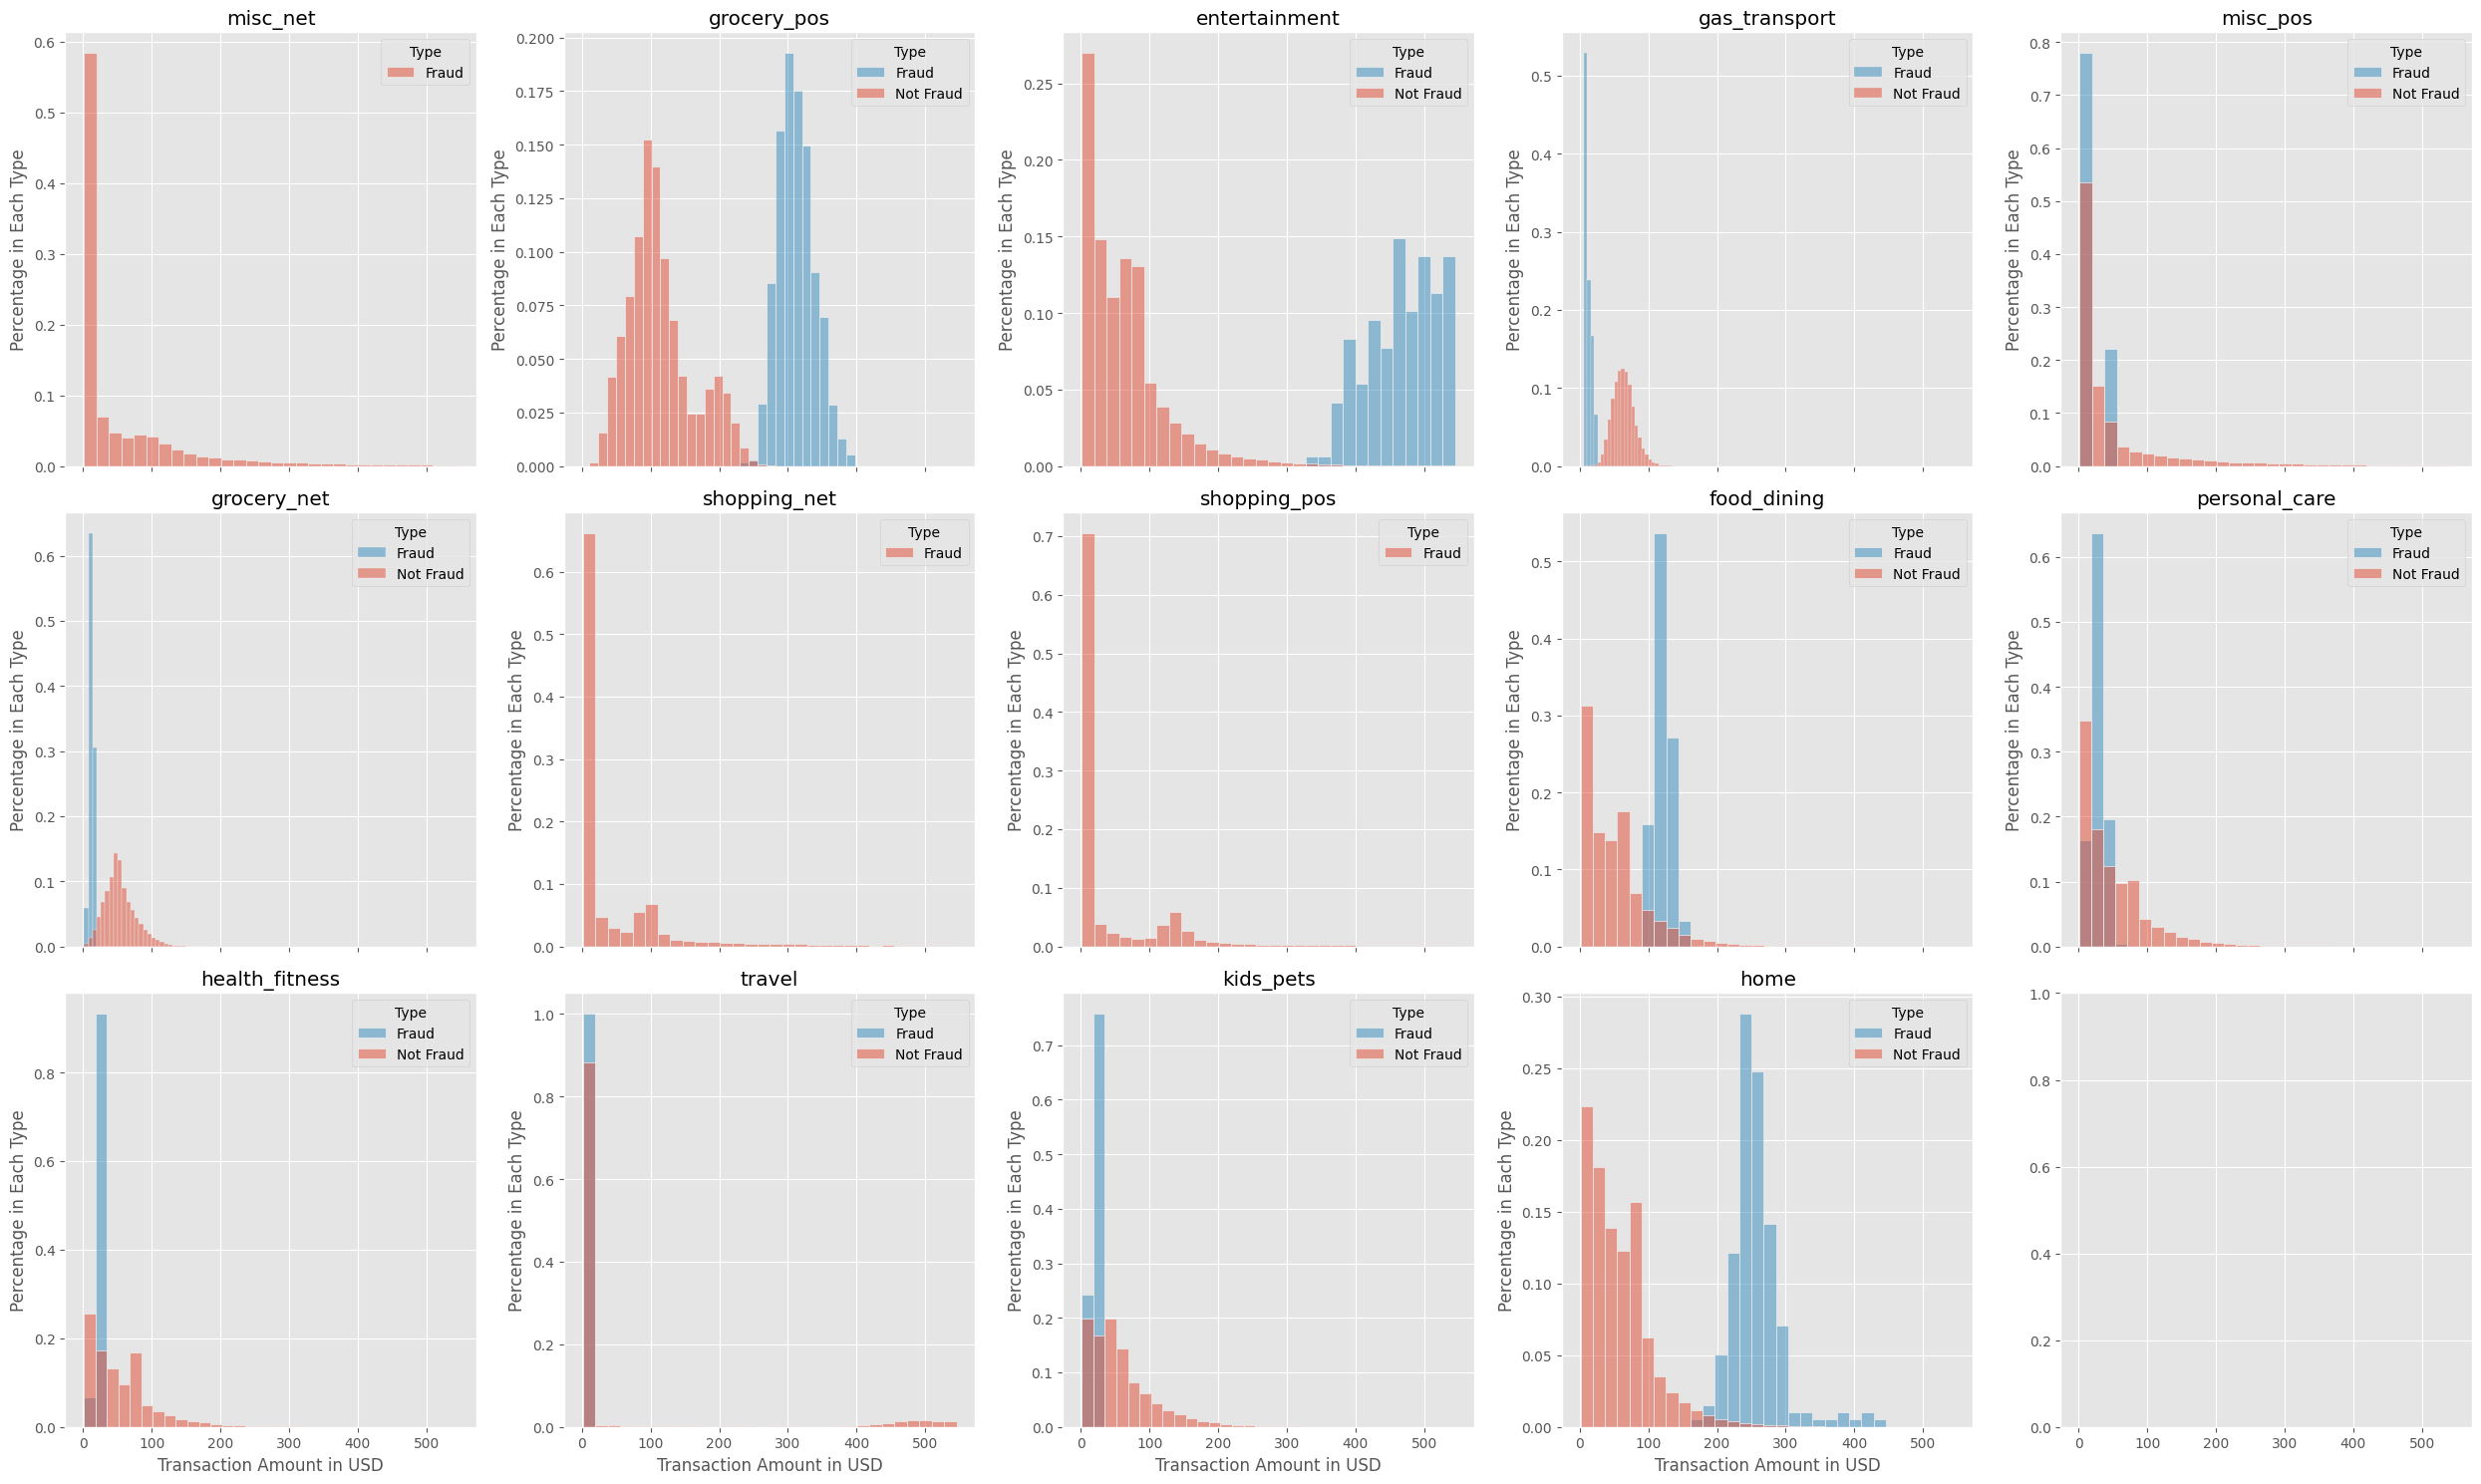

In [17]:
categories = train['category'].unique()
num_plots = len(categories)
num_rows = math.isqrt(num_plots)
num_cols = math.ceil(num_plots / num_rows)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(
    5*num_cols, 5*num_rows), sharex=True)

for i, category in enumerate(categories):

    row = i // num_cols
    col = i % num_cols

    data_category = train[train['category'] == category]

    if num_rows == 1 and num_cols == 1:
        ax = axes
    elif num_rows == 1 or num_cols == 1:
        ax = axes[i]
    else:
        ax = axes[row, col]

    sns.histplot(x='amt', data=data_category[data_category['amt'] <= p99],
                 hue='is_fraud', stat='probability',
                 common_norm=False, bins=30, ax=ax)

    ax.set_ylabel('Percentage in Each Type')
    ax.set_xlabel('Transaction Amount in USD')
    ax.set_title(f'{category}')
    ax.legend(title='Type', labels=['Fraud', 'Not Fraud'])

plt.tight_layout()

plt.show();

In [18]:
#Non-Fraud
non_fraud = train[train['is_fraud'] == 0]['category'].value_counts(
    normalize=True).to_frame().reset_index()
non_fraud.columns = ['category', 'not_fraud_percentual_vs_total']

#Fraud
fraud = train[train['is_fraud'] == 1]['category'].value_counts(
    normalize=True).to_frame().reset_index()
fraud.columns = ['category', 'fraud_percentage_vs_total']

#Calculating-Fraud Level
non_fraud_vs_fraud = non_fraud.merge(fraud, on='category')
non_fraud_vs_fraud['fraud_level'] = non_fraud_vs_fraud['fraud_percentage_vs_total'] - \
    non_fraud_vs_fraud['not_fraud_percentual_vs_total']

non_fraud_vs_fraud

,category,not_fraud_percentual_vs_total,fraud_percentage_vs_total,fraud_level
0,gas_transport,0.10,0.08,-0.02
1,home,0.10,0.03,-0.07
2,grocery_pos,0.09,0.23,0.14
3,shopping_pos,0.09,0.11,0.02
4,kids_pets,0.09,0.03,-0.06
5,shopping_net,0.07,0.23,0.15
6,entertainment,0.07,0.03,-0.04
7,food_dining,0.07,0.02,-0.05
8,personal_care,0.07,0.03,-0.04
9,health_fitness,0.07,0.02,-0.05


<ipython-input-19-988eee7f8f77>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='category', x='fraud_level',
<ipython-input-19-988eee7f8f77>:2: UserWarning: 
The palette list has fewer values (6) than needed (14) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(y='category', x='fraud_level',


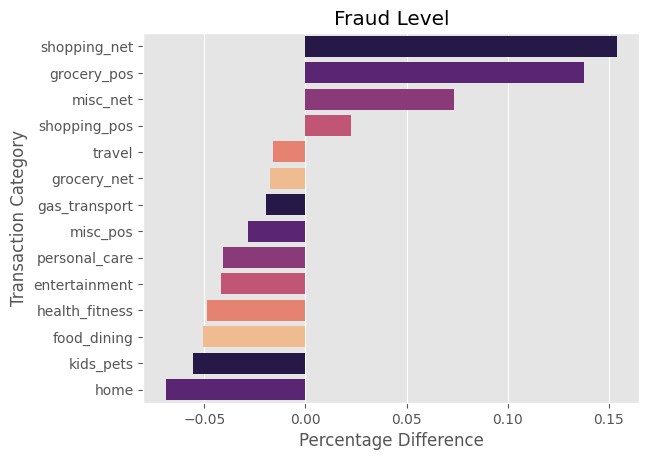

In [19]:
custom_palette = sns.color_palette("magma")
ax = sns.barplot(y='category', x='fraud_level',
                 data=non_fraud_vs_fraud.sort_values('fraud_level', ascending=False), palette=custom_palette)
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('Fraud Level');

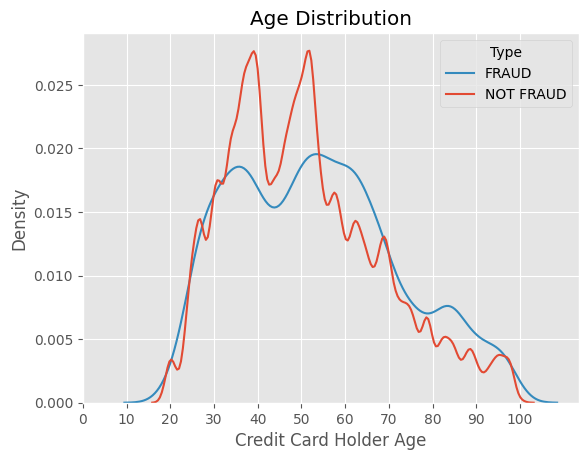

In [20]:
train['age'] = dt.date.today().year-pd.to_datetime(train['dob']).dt.year
ax = sns.kdeplot(x='age', data=train, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0, 110, 10))
plt.title('Age Distribution')
plt.legend(title='Type', labels=['FRAUD', 'NOT FRAUD']);

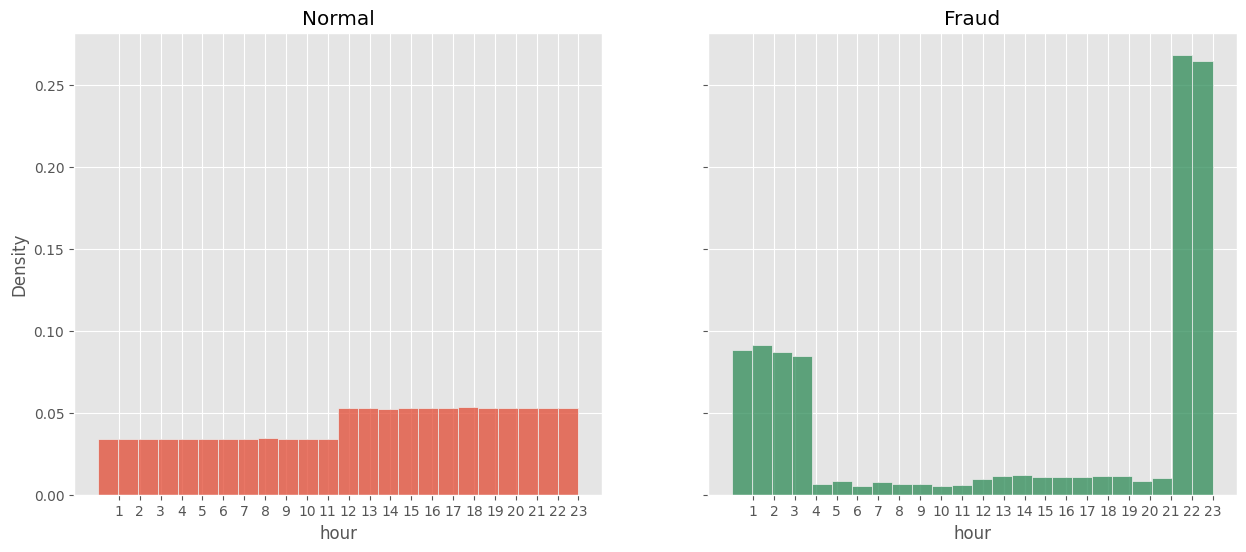

In [21]:
train['hour'] = pd.to_datetime(train['trans_date_trans_time']).dt.hour
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='hour', data=train[train["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1)
ax2 = sns.histplot(x='hour', data=train[train["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="seagreen")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 24))
ax2.set_xticks(np.arange(1, 24));

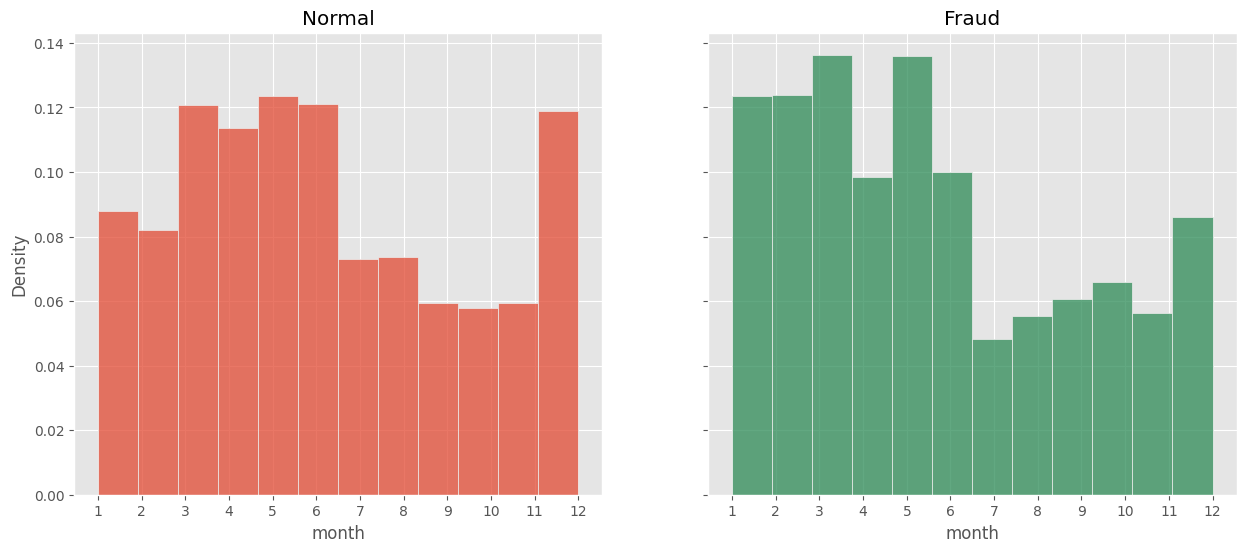

In [22]:
train['month'] = pd.to_datetime(train['trans_date_trans_time']).dt.month
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='month', data=train[train["is_fraud"] == 0],
                   stat="density", bins=12, ax=ax1)
ax2 = sns.histplot(x='month', data=train[train["is_fraud"] == 1],
                   stat="density", bins=12, ax=ax2, color="seagreen")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 13))
ax2.set_xticks(np.arange(1, 13));

In [23]:
train.drop(columns=["merchant", "first", "last", "street",
           "unix_time", "trans_num"], inplace=True)

In [24]:
train.head(2)

,trans_date_trans_time,cc_num,category,amt,gender,city,state,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,age,hour,month
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,36.01,-82.05,0,36,0,1
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,49.16,-118.19,0,46,0,1


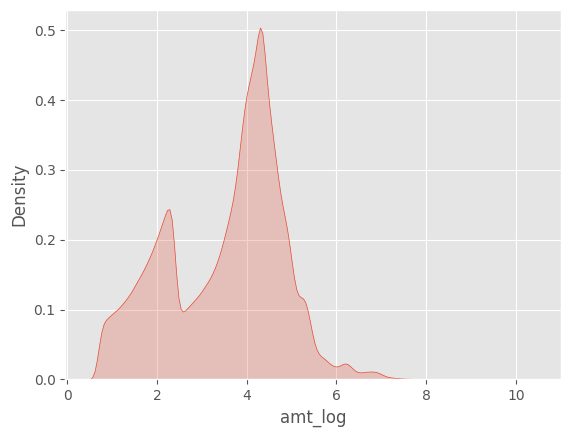

In [25]:
#Scaling
train["amt_log"] = np.log1p(train["amt"])
sns.kdeplot(train["amt_log"], fill=True);

In [26]:
def check_normality(feature):
    plt.figure(figsize=(8, 8))
    ax1 = plt.subplot(1, 1, 1)
    stats.probplot(train[feature], dist=stats.norm, plot=ax1)
    ax1.set_title(f'{feature} Q-Q plot', fontsize=20)
    sns.despine()

    mean = train[feature].mean()
    std = train[feature].std()
    skew = train[feature].skew()
    print(f'{feature} : mean: {mean:.2f}, std: {std:.2f}, skew: {skew:.2f}')

amt : mean: 70.35, std: 160.32, skew: 42.28


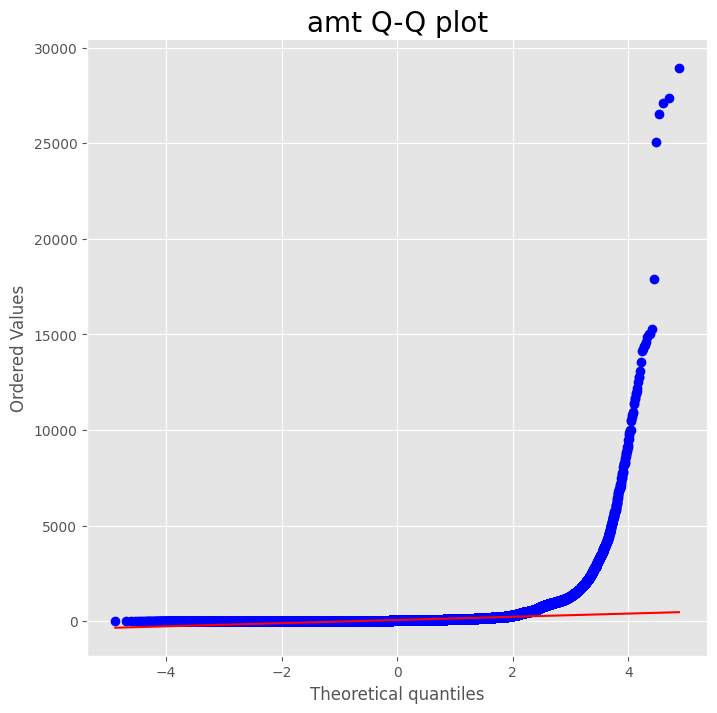

In [27]:
check_normality("amt");

amt_log : mean: 3.53, std: 1.29, skew: -0.30


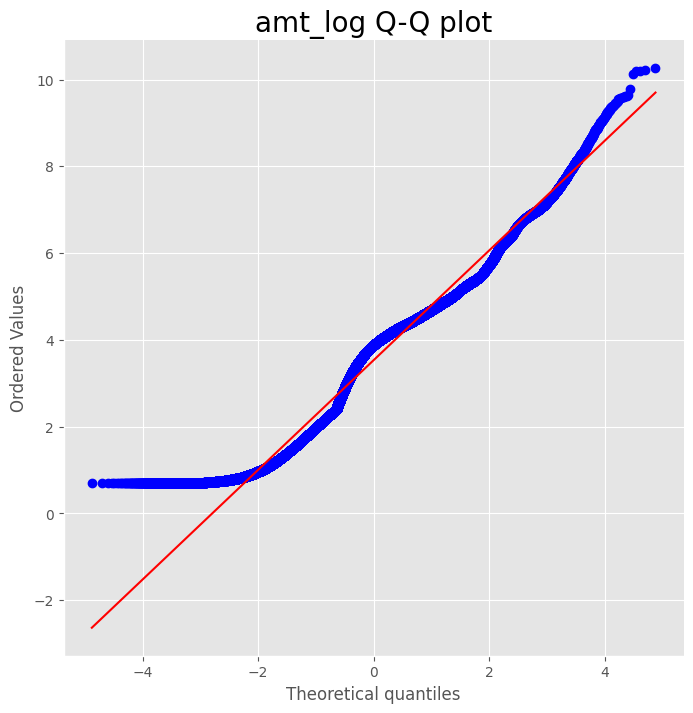

In [28]:
check_normality("amt_log");

In [29]:
def apply_woe(train, columns, target_col):
    woe = ce.WOEEncoder()
    for col in columns:
        X = train[col]
        y = train[target_col]
        new_col_name = f"{col}_WOE"
        train[new_col_name] = woe.fit_transform(X, y)
    return train

columns_to_encode = ["category", "state", "city", "job"]
target_column = "is_fraud"
train = apply_woe(train, columns_to_encode, target_column)

In [30]:
gender_mapping = {"F": 0, "M": 1}
train["gender_binary"] = train["gender"].map(gender_mapping)

In [31]:
freq_enc = (train.groupby("cc_num").size())
freq_enc.sort_values(ascending=True)
train["cc_num_frequency"] = train["cc_num"].apply(lambda x: freq_enc[x])

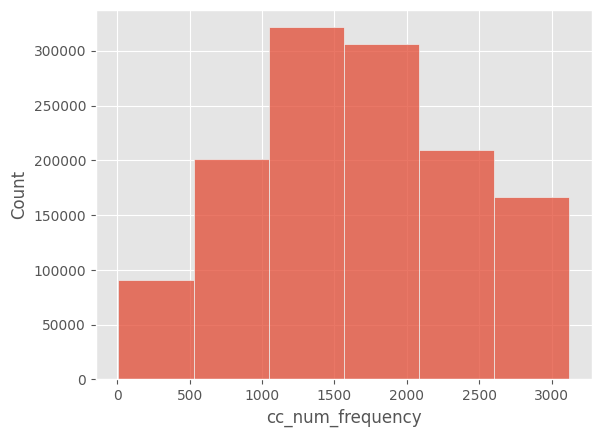

In [32]:
sns.histplot(train["cc_num_frequency"], bins=6);

In [33]:
intervals = [600, 1200, 1800, 2400, 3000, 3600]
def classify_frequency(freq):
    for i, c in enumerate(intervals):
        if freq <= c:
            return i
train["cc_num_frequency_classification"] = train["cc_num_frequency"].apply(
    classify_frequency)

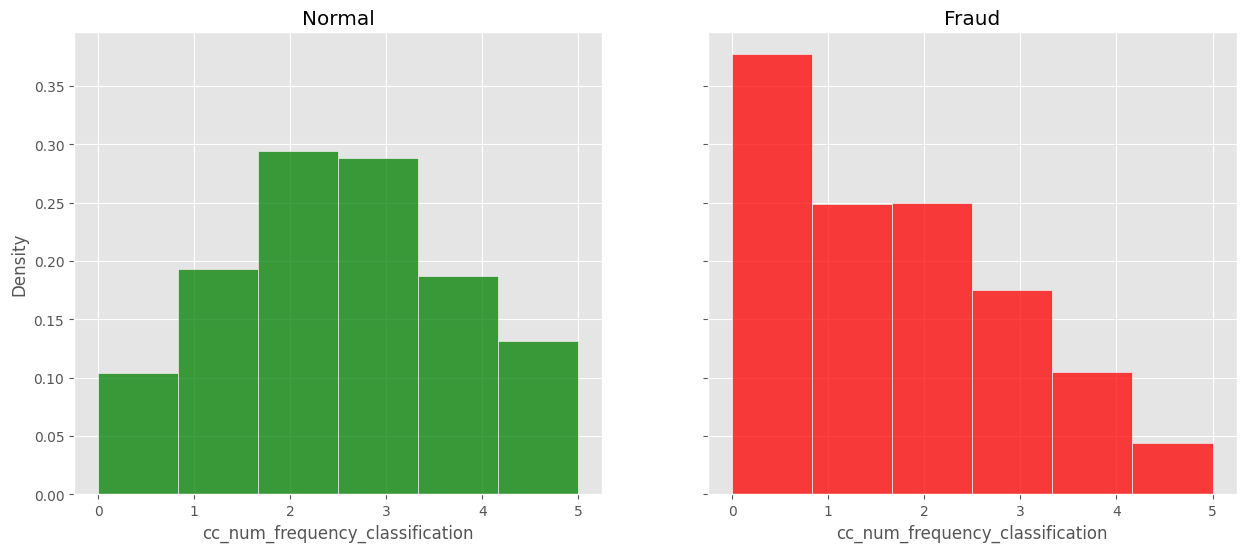

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='cc_num_frequency_classification', data=train[train["is_fraud"] == 0],
                   stat="density", bins=6, ax=ax1, color="green")
ax2 = sns.histplot(x='cc_num_frequency_classification', data=train[train["is_fraud"] == 1],
                   stat="density", bins=6, ax=ax2, color="red")
ax1.set_title("Normal")
ax2.set_title("Fraud");

In [35]:
X = train.drop(columns=["is_fraud"])
y = train["is_fraud"]

rus = RandomUnderSampler(sampling_strategy=0.1, random_state=23)
X_undersampled, y_undersampled = rus.fit_resample(X, y)

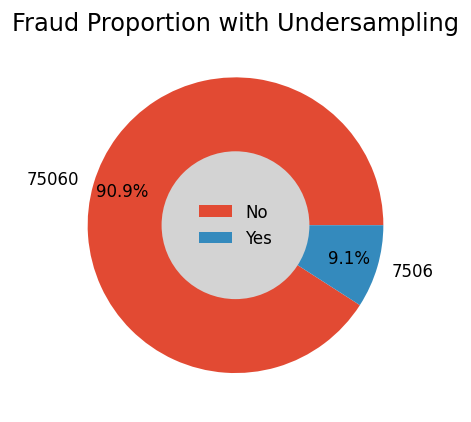

In [36]:
donut = y_undersampled.value_counts().reset_index()

labels = ["No", "Yes"]
explode = (0, 0)
fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["is_fraud"],
        labels=donut["is_fraud"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='lightgrey')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title("Fraud Proportion with Undersampling")
plt.legend(labels, loc="center", frameon=False)
plt.show();

In [37]:
X_undersampled["random_feat_1"] = np.random.randint(
    0, 100, size=len(X_undersampled))
X_undersampled["random_feat_2"] = np.random.randint(
    0, 500, size=len(X_undersampled))

In [38]:
X_train = X_undersampled.drop(columns=["trans_date_trans_time",
                                       "city", "state", "category", "gender", "dob", "job", "cc_num", "amt"])

y_train = y_undersampled

In [39]:
X_train.head()

,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,month,amt_log,category_WOE,state_WOE,city_WOE,job_WOE,gender_binary,cc_num_frequency,cc_num_frequency_classification,random_feat_1,random_feat_2
0,77566,29.04,-95.44,28739,29.24,-95.43,25,5,3,3.89,-0.21,-0.14,0.14,0.35,1,2556,4,40,104
1,12460,42.41,-74.15,277,41.56,-74.09,53,7,9,4.65,0.90,0.14,0.20,0.70,1,1548,2,32,179
2,98304,46.75,-121.99,759,46.60,-122.18,68,18,2,2.39,-0.70,-0.12,0.77,0.11,0,1040,1,48,359
3,31042,32.81,-83.17,1841,33.09,-84.14,49,5,10,3.63,-0.61,-0.03,0.00,-0.23,1,1548,2,86,323
4,99160,48.89,-118.21,149,48.08,-119.14,46,23,1,1.42,1.12,-0.12,-3.03,-0.90,0,3030,5,95,100


In [40]:
rf = RandomForestClassifier(random_state=23, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state=999)
result_boruta = feat_selector.fit(X_train.values, y_train)
accept = X_train.columns[feat_selector.support_].to_list()
irresolution = X_train.columns[feat_selector.support_weak_].to_list()
print("Features selected:")
list(accept)



Features selected:


['zip',
 'lat',
 'long',
 'city_pop',
 'merch_lat',
 'merch_long',
 'age',
 'hour',
 'month',
 'amt_log',
 'category_WOE',
 'state_WOE',
 'city_WOE',
 'job_WOE',
 'gender_binary',
 'cc_num_frequency',
 'cc_num_frequency_classification']

In [41]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
importances = rf.feature_importances_

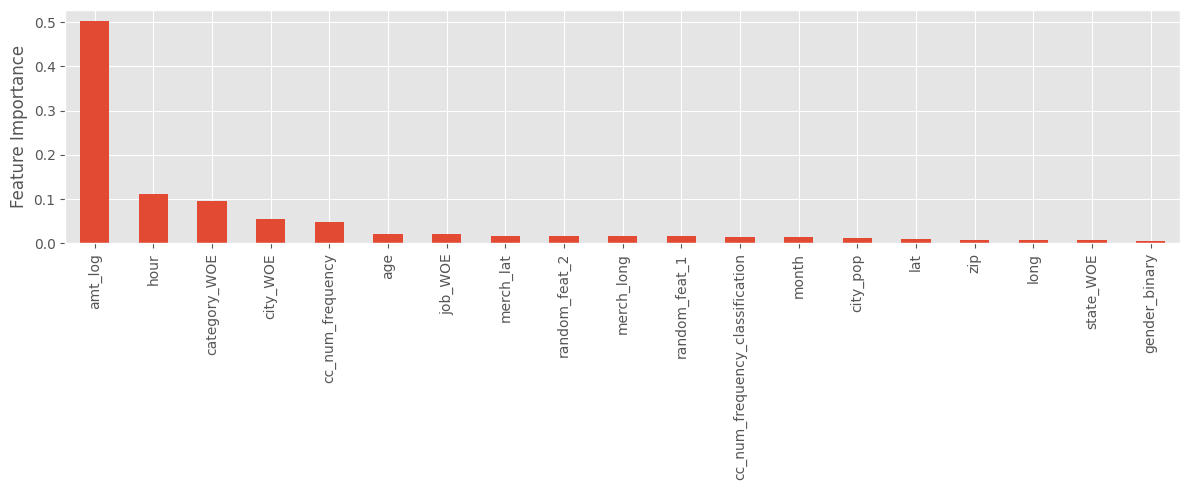

In [42]:
forest_importances = pd.Series(importances, index=X_train.columns)
fig, ax = plt.subplots(figsize=(12, 5))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_ylabel("Feature Importance")
fig.tight_layout();

In [43]:
X_train.drop(columns=["gender_binary", "state_WOE", "zip", "long", "lat",
                      "city_pop", "month", "cc_num_frequency_classification",
                      "random_feat_1", "random_feat_2", "merch_long"], inplace=True)

In [44]:
X_train.head()

,merch_lat,age,hour,amt_log,category_WOE,city_WOE,job_WOE,cc_num_frequency
0,29.24,25,5,3.89,-0.21,0.14,0.35,2556
1,41.56,53,7,4.65,0.90,0.20,0.70,1548
2,46.60,68,18,2.39,-0.70,0.77,0.11,1040
3,33.09,49,5,3.63,-0.61,0.00,-0.23,1548
4,48.08,46,23,1.42,1.12,-3.03,-0.90,3030


In [45]:
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fraudTest.csv", index_col=0)

test['age'] = dt.date.today().year-pd.to_datetime(test['dob']).dt.year
test['hour'] = pd.to_datetime(test['trans_date_trans_time']).dt.hour
test['month'] = pd.to_datetime(test['trans_date_trans_time']).dt.month

test.drop(columns=["merchant", "first", "last", "street",
                   "unix_time", "trans_num"], inplace=True)
test["amt_log"] = np.log1p(test["amt"])
test = apply_woe(test, columns_to_encode, target_column)
test["gender_binary"] = test["gender"].map(gender_mapping)
freq_enc_test = (test.groupby("cc_num").size())
freq_enc_test.sort_values(ascending=True)
test["cc_num_frequency"] = test["cc_num"].apply(lambda x: freq_enc_test[x])
test["cc_num_frequency_classification"] = test["cc_num_frequency"].apply(
    classify_frequency)

X_test = test.drop(columns=["trans_date_trans_time",
                            "city", "state", "category", "gender", "dob", "job", "cc_num", "amt", "is_fraud"])
y_test = test["is_fraud"]

X_test.drop(columns=["gender_binary", "state_WOE", "zip", "long", "lat",
                     "city_pop", "month", "cc_num_frequency_classification", "merch_long"], inplace=True)

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.2)

In [47]:
def evaluate_model(target, predicted, y_score, normalize_matrix= None):
    accuracy = metrics.accuracy_score(target, predicted)
    precision = metrics.precision_score(target, predicted)
    recall = metrics.recall_score(target, predicted)
    f1 = f1_score(target, predicted)
    auc = metrics.roc_auc_score(target, y_score)

    confusion_matrix = metrics.confusion_matrix(
        target, predicted, normalize=normalize_matrix)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=[False, True])
    cm_display.plot()
    plt.grid(False)
    plt.show()

    fpr, tpr, threshold = roc_curve(target, y_score)
    plt.plot(fpr, tpr, label="Model", c="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", c="yellow")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    print("Accuracy", accuracy.round(2))
    print("Precision:", precision.round(2))
    print("Recall:", recall.round(2))
    print("F1 Score", f1.round(2))
    print("AUC:", auc)
    return None

**Now we will test different Classification techniques**

In [48]:
rf = RandomForestClassifier(random_state=23)
knn = KNeighborsClassifier()
gboost = GradientBoostingClassifier(random_state=23)
svm = SVC()
dtc = DecisionTreeClassifier()


In [49]:
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_score_train = rf.predict_proba(X_train)[:,1]
y_pred_test = rf.predict(X_test)
y_score_test = rf.predict_proba(X_test)[:,1]

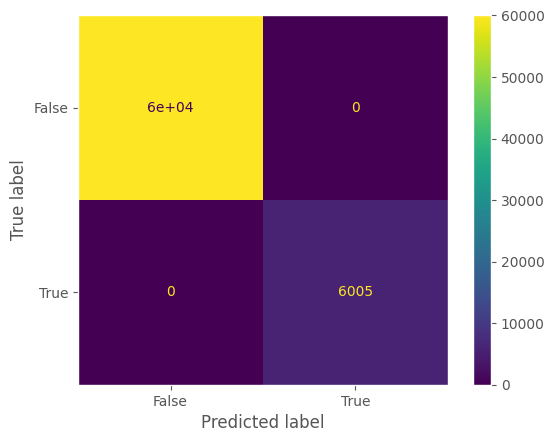

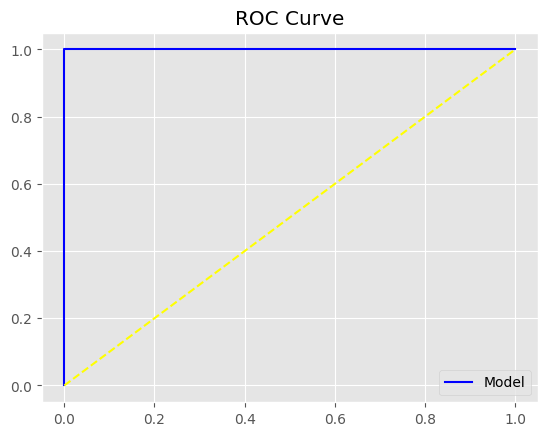

Accuracy 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0
AUC: 0.9999999999999999


In [50]:
#training
evaluate_model(y_train, y_pred_train, y_score_train)

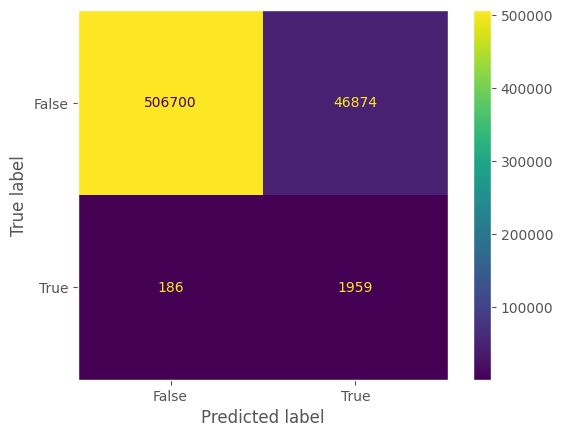

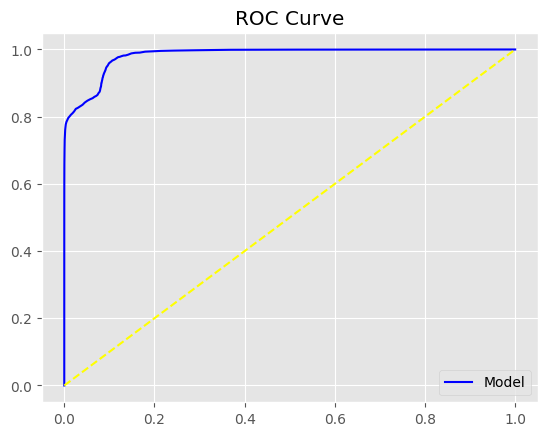

Accuracy 0.92
Precision: 0.04
Recall: 0.91
F1 Score 0.08
AUC: 0.9828778456228444


In [51]:
#Test
evaluate_model(y_test, y_pred_test, y_score_test)

In [52]:
knn.fit(X_train, y_train)
y_pred_train = knn.predict(X_train)
y_score_train = knn.predict_proba(X_train)[:,1]
y_pred_test = knn.predict(X_test)
y_score_test = knn.predict_proba(X_test)[:,1]

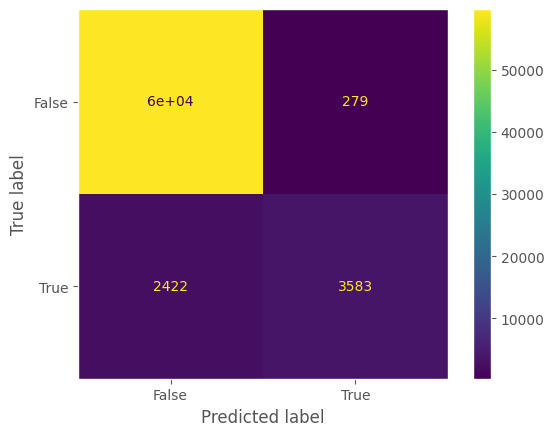

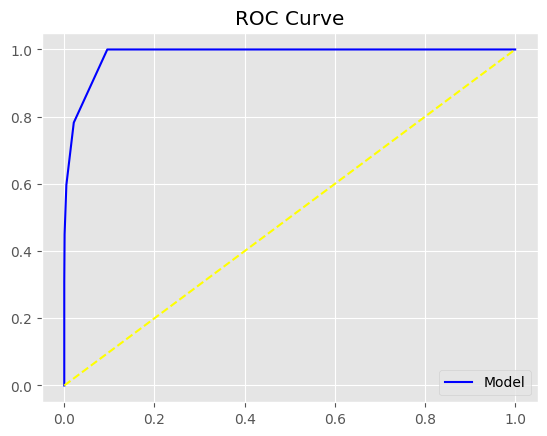

Accuracy 0.96
Precision: 0.93
Recall: 0.6
F1 Score 0.73
AUC: 0.9844834563189171


In [53]:
#Train
evaluate_model(y_train, y_pred_train, y_score_train)

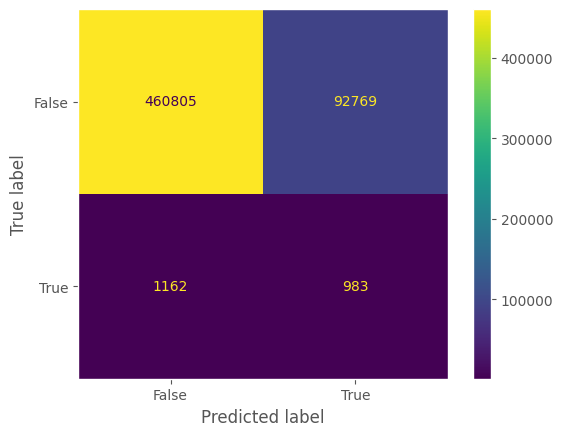

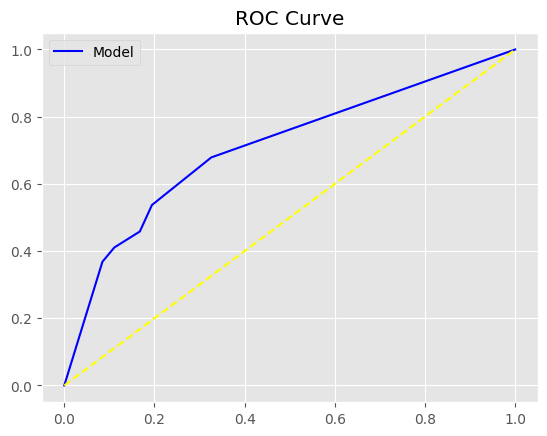

Accuracy 0.83
Precision: 0.01
Recall: 0.46
F1 Score 0.02
AUC: 0.7095013304643814


In [54]:
#Test
evaluate_model(y_test, y_pred_test, y_score_test)

In [55]:
gboost.fit(X_train, y_train)
y_pred_train = gboost.predict(X_train)
y_score_train = gboost.predict_proba(X_train)[:,1]
y_pred_test = gboost.predict(X_test)
y_score_test = gboost.predict_proba(X_test)[:,1]

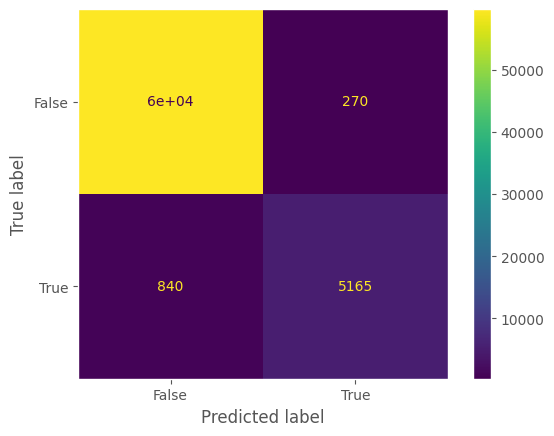

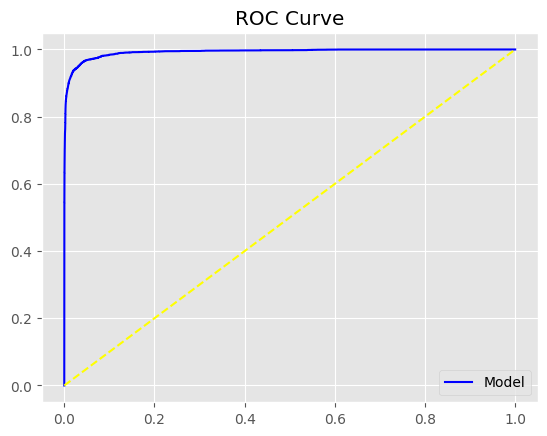

Accuracy 0.98
Precision: 0.95
Recall: 0.86
F1 Score 0.9
AUC: 0.9927594921585642


In [56]:
#Train
evaluate_model(y_train, y_pred_train, y_score_train)

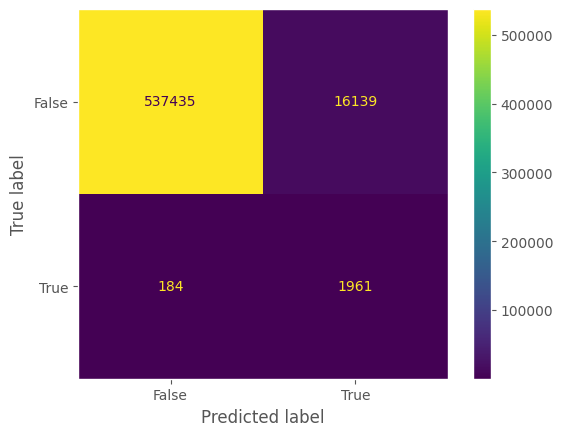

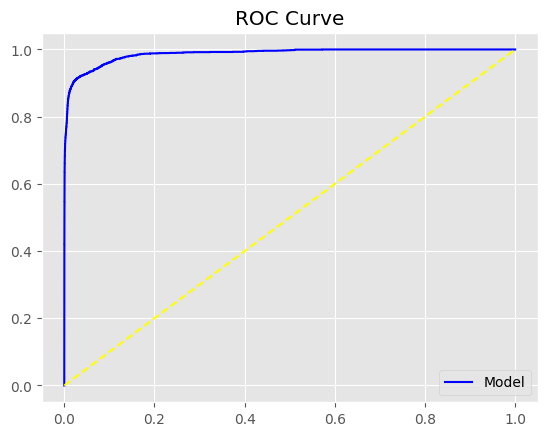

Accuracy 0.97
Precision: 0.11
Recall: 0.91
F1 Score 0.19
AUC: 0.9870572886644813


In [57]:
#Test
evaluate_model(y_test, y_pred_test, y_score_test)

In [58]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)

y_score_train = dtc.predict_proba(X_train)[:,1]
y_score_test = dtc.predict_proba(X_test)[:,1]

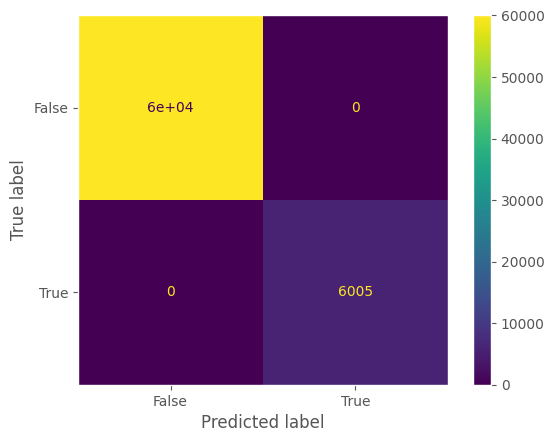

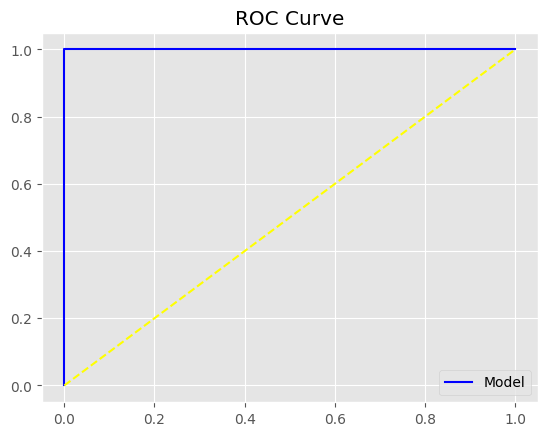

Accuracy 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0
AUC: 1.0


In [59]:
#Train
evaluate_model(y_train, y_pred_train, y_score_train)

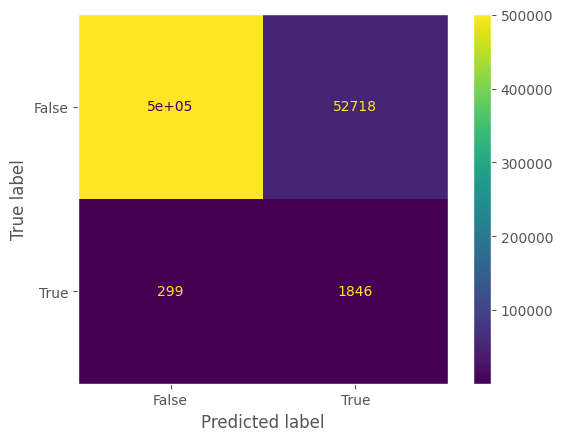

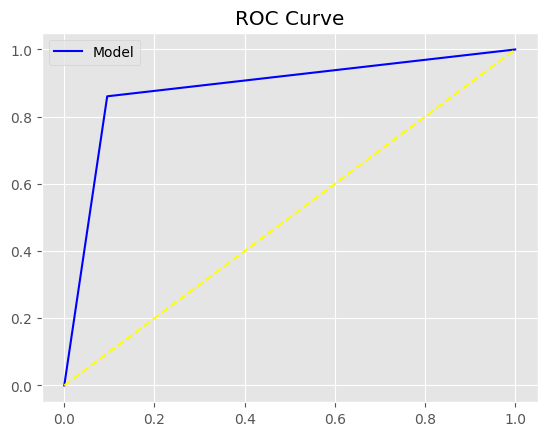

Accuracy 0.9
Precision: 0.03
Recall: 0.86
F1 Score 0.07
AUC: 0.8826869934226854


In [60]:
#Test
evaluate_model(y_test, y_pred_test, y_score_test)

In [61]:
svm.fit(X_train, y_train)

y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)

y_score_train = svm.decision_function(X_train)
y_score_test = svm.decision_function(X_test)

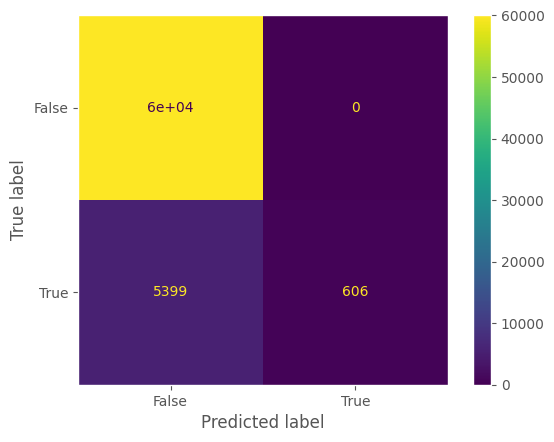

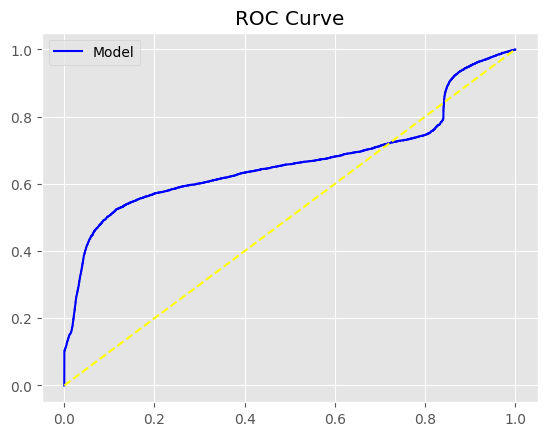

Accuracy 0.92
Precision: 1.0
Recall: 0.1
F1 Score 0.18
AUC: 0.6681209156075035


In [62]:
#Train
evaluate_model(y_train, y_pred_train, y_score_train)

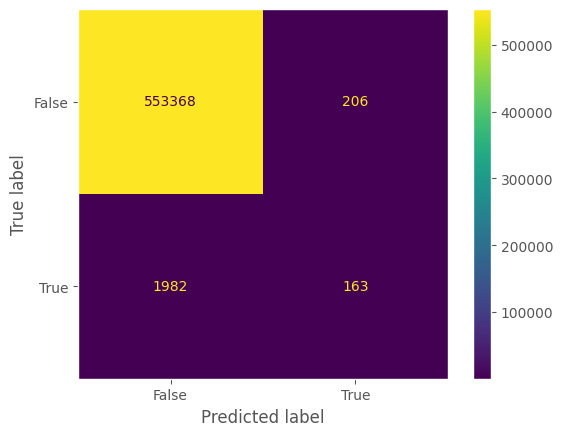

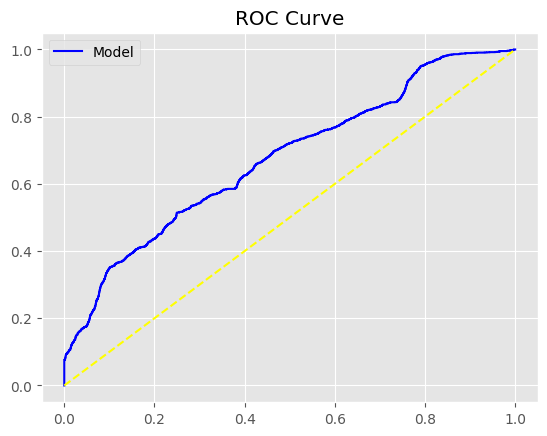

Accuracy 1.0
Precision: 0.44
Recall: 0.08
F1 Score 0.13
AUC: 0.6748512911938218


In [63]:
#Test
evaluate_model(y_test, y_pred_test, y_score_test)

In [64]:
def tune_lgbm(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]

    print(params)

    mdl = LGBMClassifier(learning_rate= learning_rate,
                         num_leaves= num_leaves,
                         min_child_samples= min_child_samples,
                         subsample= subsample,
                         colsample_bytree= colsample_bytree,
                         random_state=23, subsample_freq=1,
                         n_estimators=200)

    mdl.fit(X_train, y_train)

    y_pred = mdl.predict(X_valid)

    return -metrics.f1_score(y_valid, y_pred)

In [65]:
space = [(1e-3, 1e-1, "log-uniform"), #learning_rate
        (2,128), #num_leaves
        (1,100), #min_child_samples
        (0.05, 1.0), #subsample
        (0.1, 1.0)] #colsample_bytree

In [66]:
results = gp_minimize(tune_lgbm, space, random_state=23,
                      verbose=1, n_calls=100, n_random_starts=20)

Iteration No: 1 started. Evaluating function at random point.
[0.021786840314037433, 25, 78, 0.5952129636704409, 0.4977223159193984]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.0990
Function value obtained: -0.9055
Current minimum: -0.9055
Iteration No: 2 started. Evaluating function at random point.
[0.002333405878539521, 15, 23, 0.8416721432755412, 0.4840888306663812]
[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing row-wis

In [67]:
params = results.x
params

[0.04768796920360596, 79, 100, 1.0, 1.0]

In [68]:
learning_rate = params[0]
num_leaves = params[1]
min_child_samples = params[2]
subsample = params[3]
colsample_bytree = params[4]

In [69]:
#LightGBM
lgbm = LGBMClassifier(learning_rate= learning_rate,
                      num_leaves= num_leaves,
                      min_child_samples= min_child_samples,
                      subsample= subsample,
                      colsample_bytree= colsample_bytree,
                      random_state=23, subsample_freq=1,
                      n_estimators=200)
lgbm.fit(X_train, y_train)

y_pred_train = lgbm.predict(X_train)
y_score_train = lgbm.predict_proba(X_train)[:,1]

y_pred_test = lgbm.predict(X_test)
y_score_test = lgbm.predict_proba(X_test)[:,1]

[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535


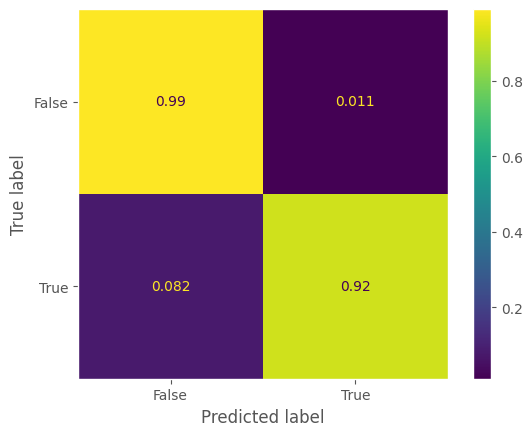

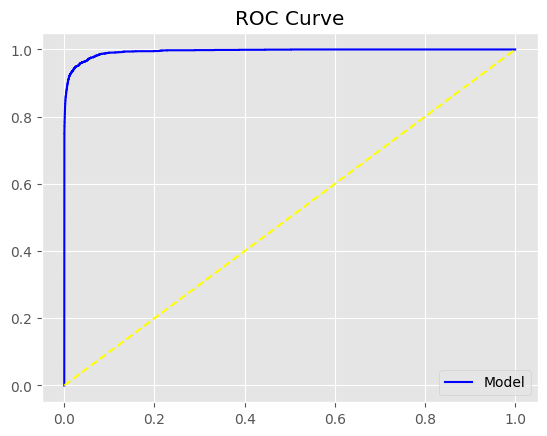

Accuracy 0.99
Precision: 0.25
Recall: 0.92
F1 Score 0.39
AUC: 0.994596126583178


In [70]:
evaluate_model(y_test, y_pred_test, y_score_test, normalize_matrix="true")

In [87]:
y_pred = lgbm.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    553574
           1       0.25      0.92      0.39      2145

    accuracy                           0.99    555719
   macro avg       0.63      0.95      0.69    555719
weighted avg       1.00      0.99      0.99    555719




**CONCLUSION:**
    
    In this problem, it is crucial to look at other metrics besides accuracy. As we saw, accuracy is one of the worst metrics for this problem, because of the natural imbalance of the dataset.

    Since our event is related to fraud transactions, i assume the worst cenarios was getting high false negatives (transactions that we identify as non-frauds and ended up being fraudulents). Hence, we used an aproach to consider the recall metric being the most important for the model.

    Also, the precision of the model is very sensitive, because of the target imbalance. As you can see, only 0.71% or normal transactions were false positives, and it dropped the precision to 33%. That is because a small percentage of normal transactions if predicted wrong, means a high number of events compared to the fraud events in dataset.

    The best approach to this problem would be having a way to calculate the mean cost of each false positive and false negative. This way, we could approach this tradeoff with better understanding of how much false positives and false negatives costs for the company.

